In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

## Продалжаем здессь [DecisionTree_CART_3](DecisionTree_CART_3.ipynb)

### Созданные функции рание
* find_candidates_for_thresholds(x, y) ищит экстремум(вкаком месте меняется)
    1. сортирует X по возврастанию и удаляет дубликаты
    2. ищет среднее значение X между соседних значений и удоляет nan
    3. формируем Y по индексу оставшихся X
    4. находим изменения Y (да=1 нет=0)
    5. фильтруем X по значению изменения Y=1

* split(X, y, split_params) делит выборку на правую илевую по критерию 'split_params'

* calculate_weighted_impurity(X, y, split_params, criterion) производит подсчет 'criterion' разделенной выборки с помощью 'split(X, y, split_params)'

* best_split(X, y, criterion) ищит наилучшие разделение выборки 
    1. перебираем по столбцам X и отправляем столбец в 'find_candidates_for_thresholds(x, y)'
    2. полученное из 'find_candidates_for_thresholds(x, y)' перебираем и отпровляем в 'calculate_weighted_impurity(X, y, split_params, criterion)'
    3. из полученных значений 'calculate_weighted_impurity(X, y, split_params, criterion)' ищим наименьшее и сохраняем его значения и параметры его получения
    4. возвращаем параметры разбиения выборки


In [7]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

In [8]:
def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t # записываем True или False выполнения условия равное количеству X   
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

In [9]:
def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

In [10]:
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

Для начала создадим вспомогательный класс вершины. У него будут следующие атрибуты:
* left — ссылка на левого потомка;
* right — ссылка на правого потомка;
* value — ответ алгоритма;
* split_params — параметры разбиения (сплита);
* impurity — неоднородность в вершине (пригодится для расчёта важности признаков);
* samples — количество объектов, попавших в вершину;
* is_leaf — булева переменная, которая указывает, является ли вершина листовой.

По умолчанию все параметры заданы как None.

In [2]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

Реализуем эту часть в виде функции create_leaf_prediction(). Она будет принимать на вход целевую переменную y и возвращать модальное значение:

In [3]:
def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

Далее введём критерий остановки. Самый базовый критерий — равенство нулю критерия информативности, рассчитанного по вершине.

In [4]:
def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

Наконец, создадим функцию build_decision_tree(). Она будет реализовывать сам рекурсивный алгоритм построения дерева решений. Функция будет принимать на вход выборку X и y, а также критерий информативности. На выходе функции должна быть корневая вершина дерева (объект класса Node). Она будет ссылаться на своих левого и правого потомка, они в свою очередь будут ссылаться на своих потоков, и так далее до самых листьев.

In [5]:
def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=criterion)
        X_left, y_left, X_right, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_right, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    
    return node

Также напишем вспомогательную функцию print_decision_tree(). Она будет принимать на вход корневую вершину дерева решений и рекурсивно выводить дерево решений в виде текста:

In [6]:
def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)

Давайте обучим наше дерево решений на игрушечном датасете о выдаче кредитов клиентам банка и напечатаем его. Напомним, что у нас есть два фактора: $x_1$ — возраст заёмщика, $x_2$ — доход заёмщика. Целевая переменная $y$ — бинарная (0 — кредит погашен, 1 — кредит не погашен).

In [11]:
# Объявляем функцию для вычисления энтропии
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

# Создаём обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan']

# Строим дерево решений и выводим его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          feature_0 <= 22.500:
             feature_0 <= 19.000:
                class: 1
             feature_0 > 19.000:
                class: 0
          feature_0 > 22.500:
             class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


Давайте сравним наш результат с деревом решений из sklearn, напечатав его в текстовом виде с помощью функции export_text() из модуля tree. Не будем ограничивать глубину дерева, а в качестве значения параметра random_state возьмём 1000 для совпадения результатов:

In [12]:
# Создаём модель дерева решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=1000 #генератор случайных чисел
)
dt.fit(X, y)
# Выводим дерево решений на экран в виде списка условий
print(tree.export_text(decision_tree=dt))

|--- feature_0 <= 43.50
|   |--- feature_1 <= 86.00
|   |   |--- feature_0 <= 22.50
|   |   |   |--- feature_0 <= 19.00
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  19.00
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  22.50
|   |   |   |--- class: 1
|   |--- feature_1 >  86.00
|   |   |--- class: 0
|--- feature_0 >  43.50
|   |--- class: 0



predict_sample() принимает на вход вершину и один объект из выборки x. Алгоритм предсказания следующий: нужно рекурсивно передвигаться по дереву на основе характеристик объекта (если $x[j] \leq t$ — в левую вершину, иначе — в правую), а когда дойдём до листовой вершины, вернуть предсказание, которое присвоено этому листу (value).

In [13]:
def predict_sample(node, x):
    if node.is_leaf:
        return node.value
    j, t = node.split_params
    if x[j] <= t:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

predict() принимает на вход дерево решений и матрицу из объектов X, для которых нужно сделать предсказание. Внутри себя функция должна сделать предсказание для всех объектов из X — вызвать функцию predict_sample(). Результат оборачивается в список, а затем в numpy-вектор.

In [14]:
def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

Проверим наши функции. Сделаем предсказание выплаты/невыплаты заёмщиком кредита для всех объектов из обучающей выборки:

In [15]:
# Предсказываем целевую переменную
y_pred = predict(decision_tree, X)
print('Predictions: {}'.format(y_pred))
# Predictions: [1 0 1 0 1 0 0 1 1 0]

Predictions: [1 0 1 0 1 0 0 1 1 0]


### Примечание. Для задачи регрессии в коде изменятся две вещи:

Функция create_leaf_prediction(). Вместо модального значения классов в листьях рассчитывается среднее значение целевой переменной:
```python
def create_leaf_prediction(y):
    value = y.mean()
    return value
```
Функция для расчёта критерия информативности (параметр criterion). В качестве критерия можно взять, например, квадратичную ошибку:
```python
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()
```

### Задание 5.3
Дана часть датасета о банкнотах, состоящая из 15 наблюдений:

```python
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']
```

In [21]:
bill_data = pd.read_csv('../../data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

### 1. Сколько вершин дерева используют в качестве признака разбиения фактор $x_1$ (Variance)?

In [17]:
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)
# # Предсказываем целевую переменную
# y_pred = predict(decision_tree, X)
# print('Predictions: {}'.format(y_pred))

    feature_1 <= 3.221:
       feature_0 <= 2.756:
          feature_0 <= -1.254:
             class: 0
          feature_0 > -1.254:
             feature_0 <= -0.063:
                class: 1
             feature_0 > -0.063:
                feature_0 <= 0.988:
                   class: 0
                feature_0 > 0.988:
                   class: 1
       feature_0 > 2.756:
          class: 0
    feature_1 > 3.221:
       class: 0


|--- feature_1 <= 3.22
|   |--- feature_0 <= 2.76
|   |   |--- feature_0 <= -1.25
|   |   |   |--- class: 0
|   |   |--- feature_0 >  -1.25
|   |   |   |--- feature_0 <= -0.06
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  -0.06
|   |   |   |   |--- feature_0 <= 0.99
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  0.99
|   |   |   |   |   |--- class: 1
|   |--- feature_0 >  2.76
|   |   |--- class: 0
|--- feature_1 >  3.22
|   |--- class: 0



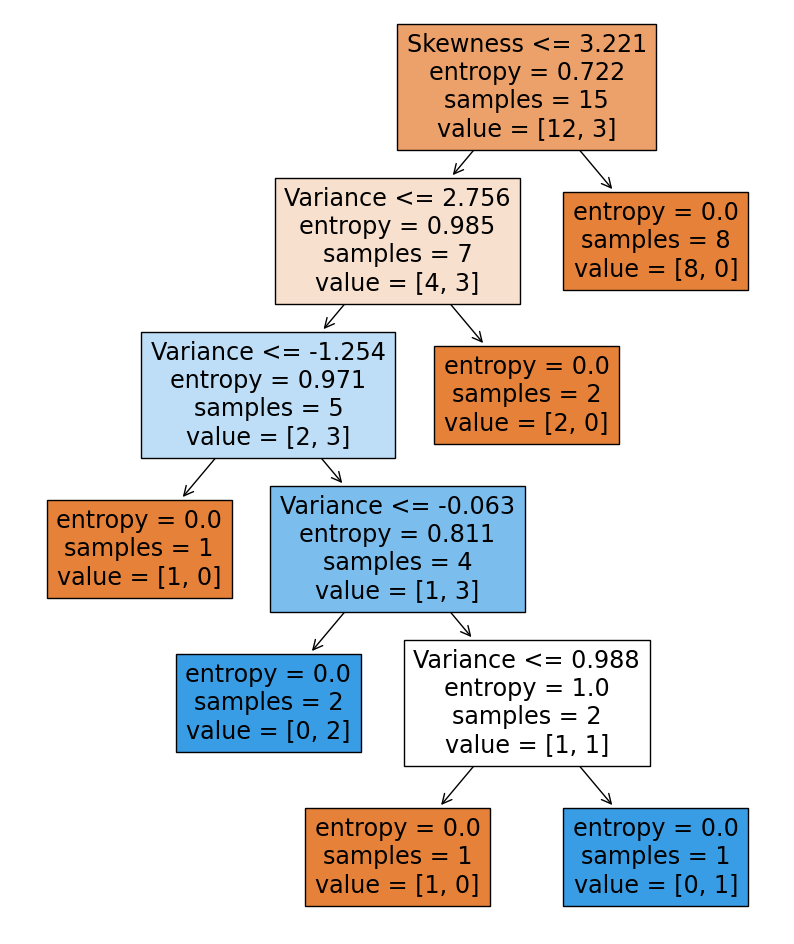

In [25]:
# Создаём модель дерева решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Выводим дерево решений на экран в виде списка условий
print(tree.export_text(decision_tree=dt))

fig = plt.figure(figsize=(10, 12))
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=list(X.columns), #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

## 1. Достижение однородности $H(Q)=0$
* 'stopping_criterion(X, y, criterion)'
* gini, равна 0,

In [26]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'y': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
# Создаём обучающую выборку
X = data[['age', 'income']]
y = data['y']

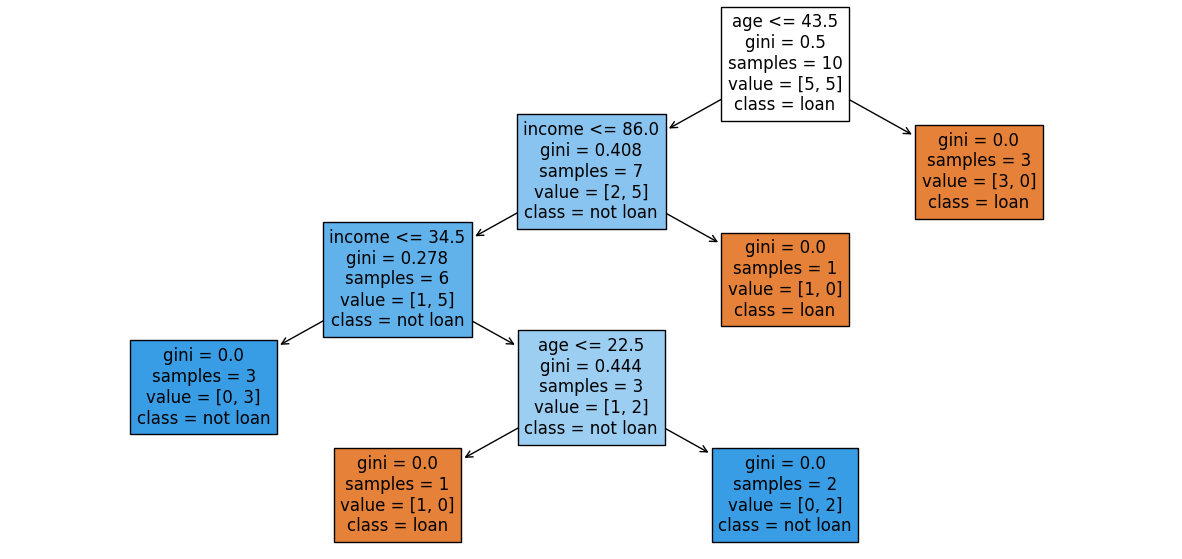

In [27]:
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

## 2. Ограничение максимальной глубины дерева (параметр max_depth)

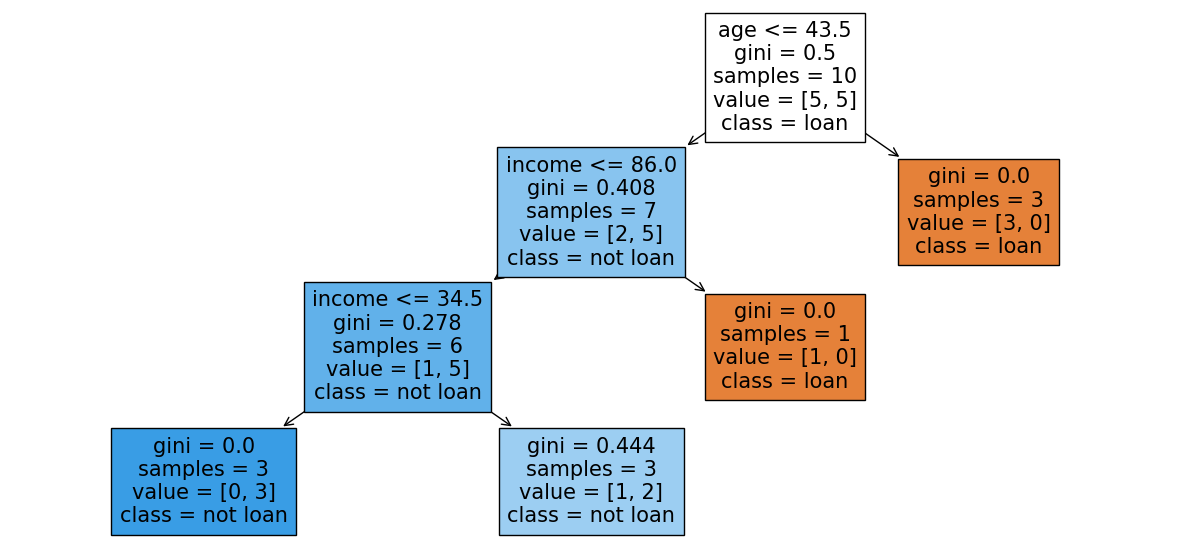

In [28]:
dt = tree.DecisionTreeClassifier(
    max_depth=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

## 3. Ограничение максимального количества листьев в дереве (параметр max_leaf_node)

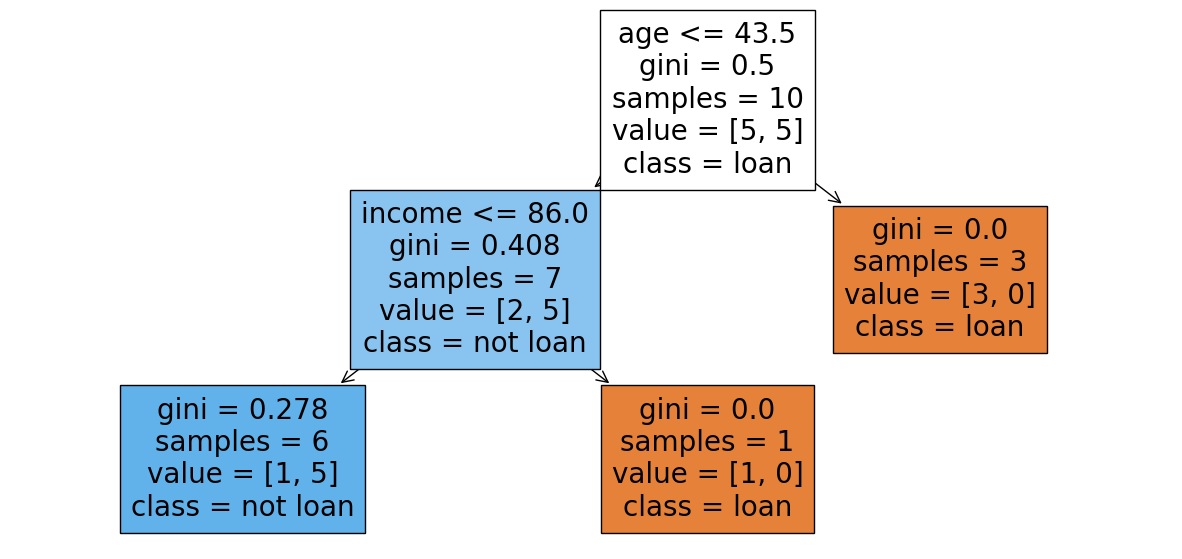

In [29]:
dt = tree.DecisionTreeClassifier(
    max_leaf_nodes=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

## 4. Ограничение на минимальное количество объектов, при которых допускается ветвление дерева (параметр min_samples_split)

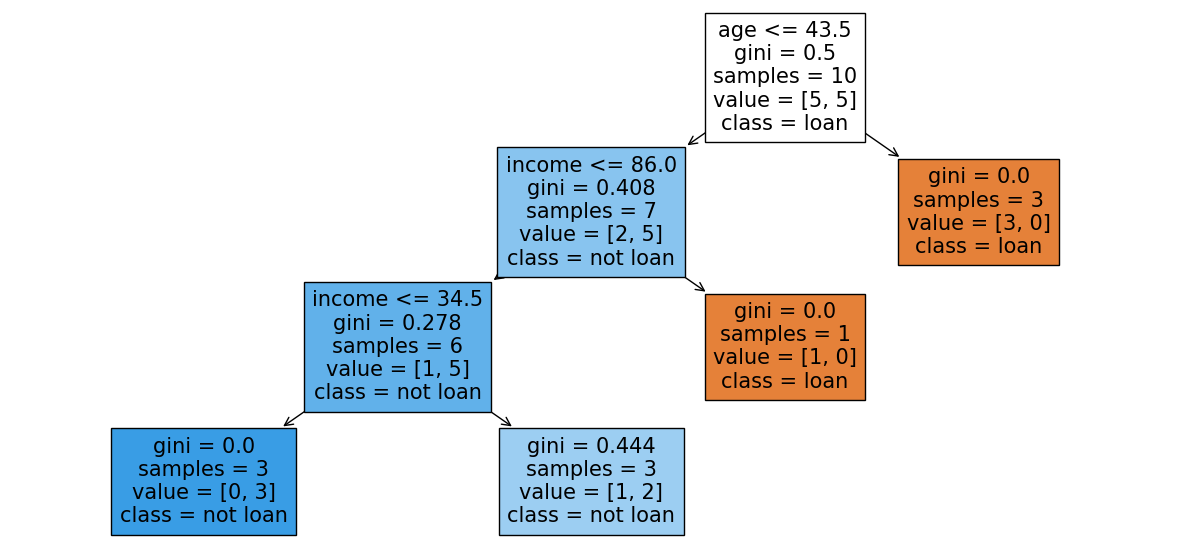

In [30]:
dt = tree.DecisionTreeClassifier(
    min_samples_split=6, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

## 5. Ограничение на минимальное количество объектов, необходимых для создания листа (параметр min_samples_leaf)

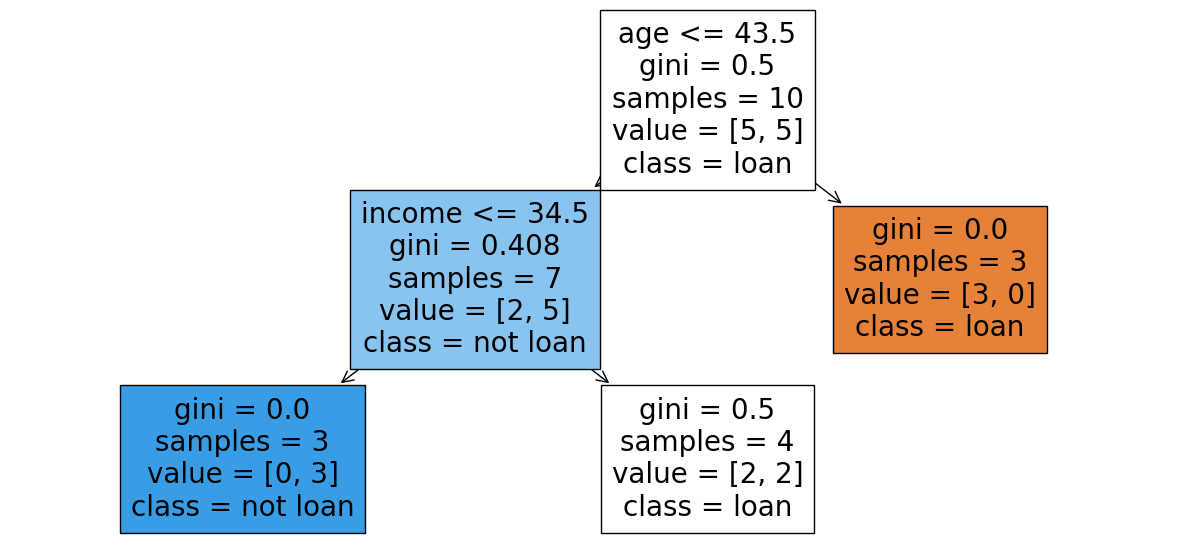

In [31]:
dt = tree.DecisionTreeClassifier(
    min_samples_leaf=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

### Дбовляем в функцию 'stopping_criterion' критерий остановки по глебине
вносим коректировки в 'stopping_criterion' и 'build_decision_tree'

In [32]:
def stopping_criterion(X, y, criterion, max_depth=None, depth=0): # коректировки
    if max_depth is None: # коректировки
        return (criterion(y) == 0) 
    else: # коректировки
        return (criterion(y) == 0) or (depth > max_depth) # коректировки
    
def build_decision_tree(X, y, criterion, max_depth=None, depth=0): # коректировки
    depth += 1 # коректировки
    if stopping_criterion(X, y, criterion, max_depth, depth): # коректировки
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth) # коректировки
        right = build_decision_tree(X_rigth, y_right, criterion, max_depth, depth) # коректировки    
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

# Строим дерево решений с ограничением глубины и печатаем его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy, max_depth=2)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


### Задание 5.4
В вершину под номером  на этапе обучения попало $N_v=18$ наблюдений. Из них 10 относятся к классу 0, а оставшиеся 8 — к классу 1. Параметр min_samples_split = 8. Произойдёт ли разделение данной вершины на две?

Дополнительные ограничения (за исключением достижения однородности) на ветвление дерева не установлены. В качестве критерия информативности используется критерий Джини